In [13]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2 #260x260
import tensorflow.keras.layers as layers
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import Sequence
import imgaug.augmenters as iaa
import imgaug

from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_colwidth', None)
data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification'
seed = 42

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_forks = pd.read_csv(data_dir+'/forks_aug.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra, df_forks], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full = df_train_full.sample(frac = 1, random_state = seed)
df_train_full.reset_index(drop = True, inplace = True)
df_train_full.head()

,Id,label,filename
0,2539,cup,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/2539.jpg"
1,eu.da4bd8ee-62cb-46fd-9422-96087866c6f4,spoon,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/eu.da4bd8ee-62cb-46fd-9422-96087866c6f4.jpg"
2,4883,spoon,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/4883.jpg"
3,1208,glass,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/1208.jpg"
4,eu.8d35c3fa-7f92-4c95-a1a4-93c5cc310d74,spoon,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/eu.8d35c3fa-7f92-4c95-a1a4-93c5cc310d74.jpg"


In [5]:
df_extra

,Id,label
0,eu.becd9fa5-82e5-4c26-8d69-350b356a002c,plate
1,eu.6cd4aa11-c74c-4407-bbf7-022e248aa379,cup
2,eu.cf9125f6-d065-41f2-a23d-d46a22e33603,glass
3,eu.a24d7ef2-0432-4c70-bbd8-4075c067884c,spoon
4,eu.9708136f-b4d2-49b1-9858-836a1da92dcd,spoon
...,...,...
2424,eu.635ea7e6-33c8-4001-9ac9-6afabfb86456,plate
2425,eu.ab04d6b1-3524-4da7-9578-efd0750f6a7b,knife
2426,eu.50858fcc-27f4-41ce-9a9c-900a385102f1,glass
2427,eu.f241d0c1-ad58-4165-baa4-17d645adfe81,glass


In [6]:
df_forks

,Id,label
0,fork_aug_0,fork
1,fork_aug_1,fork
2,fork_aug_2,fork
3,fork_aug_3,fork
4,fork_aug_4,fork
...,...,...
771,fork_aug_771,fork
772,fork_aug_772,fork
773,fork_aug_773,fork
774,fork_aug_774,fork


In [7]:
image_width = 260
image_height = 260
NUM_CLASSES = 6
batch_size = 32
n_epochs = 12
learning_rate=1e-4

In [8]:
df_train, df_val, y_train, y_val = train_test_split(df_train_full, df_train_full['label'], test_size = 0.2, shuffle = True, stratify = df_train_full['label'], random_state = seed)
df_train

,Id,label,filename
1790,6562,knife,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/6562.jpg"
4915,3616,cup,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/3616.jpg"
1227,eu.a20efbfb-459e-4f68-9095-ca76cc6fbeda,plate,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/eu.a20efbfb-459e-4f68-9095-ca76cc6fbeda.jpg"
1626,eu.5b0d6385-6b9c-4606-ac6b-61861855407d,spoon,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/eu.5b0d6385-6b9c-4606-ac6b-61861855407d.jpg"
4212,eu.c094b1db-d902-44b3-abaf-8c72eb707188,knife,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/eu.c094b1db-d902-44b3-abaf-8c72eb707188.jpg"
...,...,...,...
5060,1395,cup,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/1395.jpg"
6196,eu.6d42119e-6d19-4d0e-91a9-3a610b5441a7,cup,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/eu.6d42119e-6d19-4d0e-91a9-3a610b5441a7.jpg"
3757,eu.b3c21f3b-971f-48a3-9528-55fd850e11ff,cup,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/eu.b3c21f3b-971f-48a3-9528-55fd850e11ff.jpg"
7787,6627,glass,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/6627.jpg"


In [9]:
def build_model(num_classes):
    
    inputs = layers.Input(shape = (image_width, image_height, 3))
    x=inputs
    model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    rescale=1/255.
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    rescale=1/255.,
)

Found 7011 validated image filenames belonging to 6 classes.
Found 1753 validated image filenames belonging to 6 classes.


In [11]:
model = build_model(num_classes=NUM_CLASSES)

history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

2023-01-20 19:22:56.153301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:22:56.199868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:22:56.200084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:22:56.200502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/12


2023-01-20 19:23:03.502608: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


  1/220 [..............................] - ETA: 21:11 - loss: 2.6625 - accuracy: 0.1875

2023-01-20 19:23:04.361280: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-20 19:23:04.361926: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-20 19:23:04.361936: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-20 19:23:04.362578: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-20 19:23:04.362612: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-20 19:23:04.389795: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged onc

220/220 [==============================] - 138s 601ms/step - loss: 1.1119 - accuracy: 0.6116 - val_loss: 0.5117 - val_accuracy: 0.8871
Epoch 2/12
220/220 [==============================] - 140s 636ms/step - loss: 0.3980 - accuracy: 0.8745 - val_loss: 0.2386 - val_accuracy: 0.9264
Epoch 3/12
220/220 [==============================] - 134s 610ms/step - loss: 0.2847 - accuracy: 0.9076 - val_loss: 0.1843 - val_accuracy: 0.9401
Epoch 4/12
220/220 [==============================] - 135s 615ms/step - loss: 0.2425 - accuracy: 0.9197 - val_loss: 0.1617 - val_accuracy: 0.9481
Epoch 5/12
220/220 [==============================] - 134s 608ms/step - loss: 0.2232 - accuracy: 0.9243 - val_loss: 0.1479 - val_accuracy: 0.9527
Epoch 6/12
220/220 [==============================] - 139s 632ms/step - loss: 0.1986 - accuracy: 0.9324 - val_loss: 0.1398 - val_accuracy: 0.9538
Epoch 7/12
220/220 [==============================] - 135s 615ms/step - loss: 0.1850 - accuracy: 0.9361 - val_loss: 0.1335 - val_accura

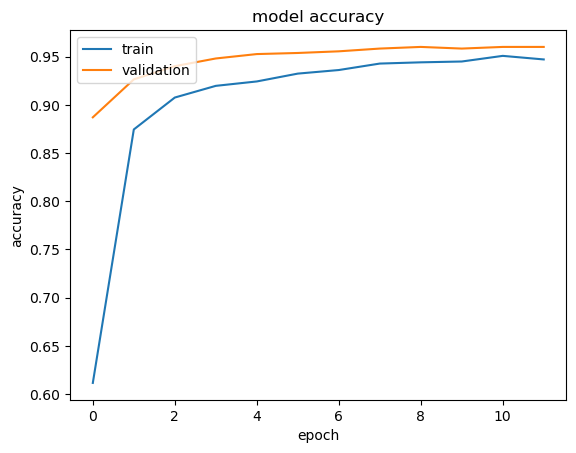

In [14]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_hist(history)

In [15]:
df_test = pd.read_csv(data_dir+'/test.csv', dtype={'Id': str})
df_test['filename'] = data_dir+'/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/0678.jpg"
1,3962,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/3962.jpg"
2,9271,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/9271.jpg"
3,5133,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/5133.jpg"
4,8842,"/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification/images/8842.jpg"


In [16]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    shuffle=False
)

Found 3808 validated image filenames.


In [17]:
y_pred = model.predict(test_generator)

119/119 [==============================] - 120s 1s/step


In [18]:
classes = np.array(list(train_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [19]:
predictions = classes[y_pred.argmax(axis=1)]

In [20]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len(data_dir+'/images/'):-4]
del df_submission['filename']

In [21]:
df_submission[['Id', 'label']].to_csv('submissions/effb2_imnet_v4_more_forks.csv', index=False)

In [22]:
!kaggle competitions submit kitchenware-classification -f submissions/effb2_imnet_v4_more_forks.csv -m 'validation: 0.9601'

100%|██████████████████████████████████████| 38.8k/38.8k [00:02<00:00, 17.2kB/s]
Successfully submitted to Kitchenware Classification